In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import spikeinterface as si
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages

from tqdm import tqdm

import sys
import spikeinterface as si
import matplotlib.pyplot as plt
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw
import spikeinterface.qualitymetrics as sqm
import json
import probeinterface

from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe, plot_probegroup
from probeinterface import generate_dummy_probe, generate_linear_probe
from probeinterface import write_probeinterface, read_probeinterface
from probeinterface import write_prb, read_prb

In [2]:
def label_array1_based_on_array2(array1, array2, threshold=5):
    """
    根据 array2 的值对 array1 进行标记。
    如果 array1 中的某个值在 threshold 范围内存在于 array2 中，则标记为 1，否则为 0。
    
    参数:
    array1 : numpy.ndarray
        要标记的数组。
    array2 : numpy.ndarray
        用于判断的数组。
    threshold : int
        判断范围的阈值。
    
    返回:
    labels : numpy.ndarray
        长度为 len(array1) 的标签数组，值为 0 或 1。
    """
    sorted_array2 = np.sort(array2)
    
    labels = np.zeros(len(array1), dtype=int)
    
    for i, value in enumerate(array1):
        left = value - threshold
        right = value + threshold
        
        left_index = np.searchsorted(sorted_array2, left, side='left')
        right_index = np.searchsorted(sorted_array2, right, side='right')
        
        if right_index > left_index:
            labels[i] = 1
    
    return labels

In [3]:
global_job_kwargs = dict(n_jobs=10, chunk_duration="1s")
si.set_global_job_kwargs(**global_job_kwargs)

In [4]:
recording_raw = se.read_blackrock(file_path='/media/ubuntu/sda/data/mouse6/ns4/natural_image/mouse6_022522_natural_image_001.ns4')
recording_recorded = recording_raw.remove_channels(['31', '32', '98'])
recording_stimulated = recording_raw.channel_slice(['98'])

In [5]:
probe_30channel = read_probeinterface('/media/ubuntu/sda/data/probe.json')
recording_recorded = recording_recorded.set_probegroup(probe_30channel)
recording_cmr = recording_recorded
recording_f = spre.bandpass_filter(recording_recorded, freq_min=300, freq_max=3000)
recording_cmr = spre.common_reference(recording_f, reference="global", operator="median")
recording_preprocessed = recording_cmr.save(format="binary")

Use cache_folder=/tmp/spikeinterface_cache/tmpv91ui4si/0MCKORNB
write_binary_recording 
n_jobs=10 - samples_per_chunk=10,000 - chunk_memory=585.94 KiB - total_memory=5.72 MiB - chunk_duration=1.00s


write_binary_recording: 100%|██████████| 2601/2601 [00:02<00:00, 896.72it/s]


In [6]:
# for i in [1, 2, 3, 4, 5]:
#     output_folder = f'whole_segment_rep{i}'
#     os.makedirs(f"/home/ubuntu/Documents/jct/project/code/Spike_Sorting/22522/{output_folder}", exist_ok=True)
#     sorting_kilosort4 = ss.run_sorter(sorter_name="kilosort4", recording=recording_preprocessed, output_folder=f'{output_folder}/kilosort')
#     analyzer_kilosort4 = si.create_sorting_analyzer(sorting=sorting_kilosort4, recording=recording_preprocessed, format='binary_folder', folder=f'{output_folder}/analyzer_kilosort4_binary')

#     extensions_to_compute = [
#             "random_spikes",
#             "waveforms",
#             "noise_levels",
#             "templates",
#             "spike_amplitudes",
#             "unit_locations",
#             "spike_locations",
#             "correlograms",
#             "template_similarity"
#         ]

#     extension_params = {
#         "unit_locations": {"method": "center_of_mass"},
#         "spike_locations": {"ms_before": 0.1},
#         "correlograms": {"bin_ms": 0.1},
#         "template_similarity": {"method": "cosine_similarity"}
#     }

#     analyzer_kilosort4.compute(extensions_to_compute, extension_params=extension_params)

#     qm_params = sqm.get_default_qm_params()
#     analyzer_kilosort4.compute("quality_metrics", qm_params)

In [7]:
channel_indices = {
        "1": [1, 3, 5, 7, 9, 11],
        "2": [13, 15, 17, 19, 21, 23],
        "3": [24, 25, 26, 27, 28, 29],
        "4": [12, 14, 16, 18, 20, 22],
        "5": [0, 2, 4, 6, 8, 10]
        }
channel_position = {
    0: [650, 0],
    2: [650, 50],
    4: [650, 100],
    6: [600, 100],
    8: [600, 50],
    10: [600, 0],
    1: [0, 0],
    3: [0, 50],
    5: [0, 100],
    7: [50, 100],
    9: [50, 50],
    11: [50, 0],
    13: [150, 200], 
    15: [150, 250],
    17: [150, 300],
    19: [200, 300],
    21: [200, 250],
    23: [200, 200],
    12: [500, 200],
    14: [500, 250],
    16: [500, 300],
    18: [450, 300],
    20: [450, 250],
    22: [450, 200],
    24: [350, 400],
    26: [350, 450],
    28: [350, 500],
    25: [300, 400],
    27: [300, 450],
    29: [300, 500]}

In [8]:
def get_spike_inf(file_path, date):
    cluster_inf = pd.read_csv(file_path + "/analyzer_kilosort4_binary/extensions/quality_metrics/metrics.csv")
    cluster_inf.columns = ['cluster', 'num_spikes', 'firing_rate', 'presence_ratio', 'snr',
                           'isi_violations_ratio', 'isi_violations_count', 'rp_contamination',
                           'rp_violations', 'sliding_rp_violation', 'amplitude_cutoff',
                           'amplitude_median', 'amplitude_cv_median', 'amplitude_cv_range',
                           'sync_spike_2', 'sync_spike_4', 'sync_spike_8', 'firing_range',
                           'drift_ptp', 'drift_std', 'drift_mad', 'sd_ratio']
    
    cluster_inf['cluster'] = cluster_inf['cluster'].astype(str)
    cluster_inf['position_1'] = None
    cluster_inf['position_2'] = None

    spike_clusters = pd.DataFrame(np.load(file_path + "/kilosort/sorter_output/spike_clusters.npy").astype(str))
    spike_positions = pd.DataFrame(np.load(file_path + "/kilosort/sorter_output/spike_positions.npy").astype(float))
    spike_templates = pd.DataFrame(np.load(file_path + "/kilosort/sorter_output/spike_templates.npy"))
    spike_times = pd.DataFrame(np.load(file_path + "/kilosort/sorter_output/spike_times.npy").astype(int))
    tf = pd.DataFrame(np.load(file_path + "/kilosort/sorter_output/tF.npy")[:, 0, :])

    spike_inf = pd.concat((spike_clusters, spike_positions, spike_templates, spike_times, tf), axis=1)
    spike_inf.columns = ['cluster', 'position_1', 'position_2', 'templates', 'time', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6']

    for i in spike_inf['cluster'].value_counts().index:
        temp = spike_inf[spike_inf['cluster'] == i]
        cluster_inf.loc[cluster_inf['cluster'] == i, 'position_1'] = np.mean(temp['position_1'])
        cluster_inf.loc[cluster_inf['cluster'] == i, 'position_2'] = np.mean(temp['position_2'])

    cluster_inf['probe_group'] = "1"

    for i in spike_inf['cluster'].value_counts().index:
        cluster_rows = cluster_inf[cluster_inf['cluster'] == i]
        if (cluster_rows['position_1'] > 100).any() and (cluster_rows['position_1'] < 250).any():
            cluster_inf.loc[cluster_inf['cluster'] == i, 'probe_group'] = "2"
        elif (cluster_rows['position_1'] > 250).any() and (cluster_rows['position_1'] < 400).any():
            cluster_inf.loc[cluster_inf['cluster'] == i, 'probe_group'] = "3"
        elif (cluster_rows['position_1'] > 400).any() and (cluster_rows['position_1'] < 550).any():
            cluster_inf.loc[cluster_inf['cluster'] == i, 'probe_group'] = "4"
        elif (cluster_rows['position_1'] > 550).any():
            cluster_inf.loc[cluster_inf['cluster'] == i, 'probe_group'] = "5"

    waveform = np.load(file_path + "/kilosort/sorter_output/templates.npy")
    cluster_inf['waveform'] = [waveform[i] for i in range(waveform.shape[0])]

    cluster_inf = cluster_inf[((cluster_inf['snr'] > 3) & (cluster_inf['num_spikes'] > int(100))) | ((cluster_inf['snr'] < 3) & (cluster_inf['num_spikes'] > 1000))]
    spike_inf = spike_inf[spike_inf['cluster'].isin(list(cluster_inf['cluster']))]
    spike_inf = spike_inf[spike_inf['time'] > 200]
    cluster_inf['date'] = date
    spike_inf['date'] = date
    
    channel_indices = {
        "1": [1, 3, 5, 7, 9, 11],
        "2": [13, 15, 17, 19, 21, 23],
        "3": [24, 25, 26, 27, 28, 29],
        "4": [12, 14, 16, 18, 20, 22],
        "5": [0, 2, 4, 6, 8, 10]
        }

    for index, row in cluster_inf.iterrows():
        probe_group = row['probe_group']
        if probe_group in channel_indices:
            selected_channels = channel_indices[probe_group]
            cluster_inf.at[index, 'waveform'] = row['waveform'][:, selected_channels]

    return cluster_inf, spike_inf

def calculate_position(row):
    probe_group = str(row['probe_group'])
    channels = channel_indices[probe_group]
    waveform = row['waveform'] 
    
    a_squared = [np.sum(waveform[:, j]**2) for j in range(len(channels))]
    
    sum_x_a = 0
    sum_y_a = 0
    sum_a = 0
    
    for j, channel in enumerate(channels):
        x_i, y_i = channel_position.get(channel, [0, 0])  
        a_i_sq = a_squared[j]
        
        sum_x_a += x_i * a_i_sq
        sum_y_a += y_i * a_i_sq
        sum_a += a_i_sq
    
    if sum_a == 0:
        return pd.Series({'position_1': 0, 'position_2': 0})
    
    x_hat = sum_x_a / sum_a
    y_hat = sum_y_a / sum_a
    return pd.Series({'position_1': x_hat, 'position_2': y_hat})

def calculate_position_waveform(row, channel_position, channel_indices, power=2):
    x_target = row['position_1']
    y_target = row['position_2']
    probe_group = str(row['probe_group'])
    channels = channel_indices[probe_group]  
    waveforms = row['waveform']  
    
    distances = []
    for channel in channels:
        x_channel, y_channel = channel_position.get(channel, [np.nan, np.nan])
        if np.isnan(x_channel):  
            continue
        distance = np.sqrt((x_target - x_channel)**2 + (y_target - y_channel)**2)
        distances.append(distance)
    
    if not distances:  
        return np.zeros(61)
    
    #IDW
    weights = 1 / (np.array(distances) ** power)
    if np.any(distances == 0):
        zero_idx = np.argwhere(distances == 0).flatten()
        return waveforms[:, zero_idx[0]]
    
    weights /= np.sum(weights)
    
    synthesized_waveform = np.zeros(61)
    for t in range(61): 
        weighted_sum = np.dot(waveforms[t, :], weights)
        synthesized_waveform[t] = weighted_sum
    
    return synthesized_waveform

In [9]:
all_cluster_inf = pd.DataFrame()
all_spike_inf = pd.DataFrame()

for date in ['1', '2', '3', '4', '5']:
    cluster_inf, spike_inf = get_spike_inf(file_path=f"/home/ubuntu/Documents/jct/project/code/Spike_Sorting/sorting_results/022522/whole_segment_rep{date}", date = date)
    all_cluster_inf = pd.concat([all_cluster_inf, cluster_inf], ignore_index=True)
    all_spike_inf = pd.concat([all_spike_inf, spike_inf], ignore_index=True)

In [10]:
all_cluster_inf[['position_1', 'position_2']] = all_cluster_inf.apply(calculate_position, axis=1)
all_cluster_inf['Neuron'] = None
current_max_neuron = 1  

for i in range(1, len(all_cluster_inf)):
    current_pos1 = all_cluster_inf.at[i, 'position_1']
    current_pos2 = all_cluster_inf.at[i, 'position_2']
    
    mask = (
        (all_cluster_inf.loc[:i-1, 'position_1'] - current_pos1).abs().lt(3) & 
        (all_cluster_inf.loc[:i-1, 'position_2'] - current_pos2).abs().lt(5)
    )
    
    matched = all_cluster_inf.loc[:i-1][mask]
    
    if not matched.empty:
        all_cluster_inf.at[i, 'Neuron'] = matched['Neuron'].iloc[-1]
    else:
        current_max_neuron += 1
        all_cluster_inf.at[i, 'Neuron'] = f'Neuron_{current_max_neuron}'

neuron_date = pd.crosstab(all_cluster_inf['Neuron'], all_cluster_inf['date'])   
neuron_date[neuron_date > 1] = 1
neuron_date = neuron_date.sum(axis=1)
neuron_date = neuron_date[neuron_date == 5]
neuron_date = neuron_date.index

all_cluster_inf = all_cluster_inf[all_cluster_inf['Neuron'].isin(neuron_date)]
all_cluster_inf['cluster_date'] = all_cluster_inf['date']  + "_" +  all_cluster_inf['cluster']

all_cluster_inf['position_waveform'] = None
for idx, row in all_cluster_inf.iterrows():
    all_cluster_inf.at[idx, 'position_waveform'] = calculate_position_waveform(row, channel_position, channel_indices, 2)

In [11]:
waveform_dict = {}
for neuron in all_cluster_inf['Neuron']:
    temp = all_cluster_inf[all_cluster_inf['Neuron'] == neuron]
    temp.index = temp['cluster_date']
    waveform_dict[neuron] = temp['position_waveform'].apply(pd.Series)

In [12]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

num = 0
results = {}

for _, df in waveform_dict.items():
    
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(df)

    eps = 3
    min_samples = 1

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(principal_components)

    label = pd.DataFrame(dbscan.labels_, columns=['labels'])
    label['cluster_date'] = df.index
    label['date'] = label['cluster_date'].apply(lambda x: x.split('_')[0]+"_" + x.split('_')[1])

    remain_label = label['labels'].value_counts()
    remain_label = remain_label[remain_label >= 5]
    for i in remain_label.index:
        temp = label[label['labels'] == i]
        if temp['date'].nunique() != 5:
            remain_label = remain_label.drop(i)
    label = label[label['labels'].isin(remain_label.index)]
    for i in label['labels'].unique():
        results[num] = label.loc[label['labels'] ==i, 'cluster_date'].values
        num += 1

In [13]:
all_cluster_inf['Neuron'] = None
for key,item in results.items():
    all_cluster_inf.loc[all_cluster_inf['cluster_date'].isin(item), 'Neuron'] = f'Neuron_{key+1}'

all_cluster_inf = all_cluster_inf.dropna(subset=['Neuron'])
all_cluster_inf['neuron_date'] = all_cluster_inf['date'] + "_" + all_cluster_inf['Neuron']

In [14]:
waveform_mean = pd.DataFrame()
for _, df in waveform_dict.items():
    waveform_mean = pd.concat((waveform_mean, df), axis=0)
waveform_mean = waveform_mean.loc[list(all_cluster_inf['cluster_date'])]

all_cluster_inf = all_cluster_inf.set_index('cluster_date')
all_cluster_inf = all_cluster_inf.join(waveform_mean, how="right")

In [15]:
all_cluster_inf['cluster_date'] = all_cluster_inf.index
all_spike_inf['cluster_date'] = all_spike_inf['date']  + "_" +  all_spike_inf['cluster']
all_spike_inf = all_spike_inf[all_spike_inf['cluster_date'].isin(all_cluster_inf['cluster_date'].values)]

all_spike_inf['Neuron'] = None
for i in range(len(all_cluster_inf)):
    all_spike_inf.loc[all_spike_inf['cluster_date'] == all_cluster_inf.iloc[i, -1], "Neuron"] = all_cluster_inf.iloc[i, 27]


In [16]:
all_cluster_inf_rep1 = all_cluster_inf[all_cluster_inf['date'] == '1']

In [17]:
all_spike_inf_rep1 = all_spike_inf[all_spike_inf['date'] == '1']
del_neuron = all_spike_inf_rep1['Neuron'].value_counts().index[(all_spike_inf_rep1['Neuron'].value_counts() < 8000)]
all_cluster_inf_rep1 = all_cluster_inf_rep1[~all_cluster_inf_rep1['Neuron'].isin(del_neuron)]

In [18]:
all_cluster_inf_rep1['channel_id'] = None
for index, row in all_cluster_inf_rep1.iterrows():
    probe_group = row['probe_group']
    if probe_group in channel_indices:
        all_cluster_inf_rep1.at[index, 'channel_id'] = channel_indices[probe_group]

In [19]:
waveform = recording_cmr.get_traces().astype("float32")
all_spike_inf_rep1 = all_spike_inf_rep1[all_spike_inf_rep1['time'] < waveform.shape[0] - 35]

for i in range(len(all_cluster_inf_rep1)):
    neuron = all_cluster_inf_rep1['Neuron'].values[i]
    channel_id = all_cluster_inf_rep1['channel_id'].values[i]

    spike_temp = all_spike_inf_rep1[all_spike_inf_rep1['Neuron'] == neuron]
    waveform_temp = waveform[:, channel_id].T

    n = len(spike_temp)  
    n_channels = 6     
    waveform_length = 61 

    waveform_stack = np.zeros((n, n_channels, waveform_length)).astype(np.float32)

    for j in range(n):
        start = spike_temp['time'].values[j] - 30
        end = spike_temp['time'].values[j] + 31
        waveform_stack[i, :, :] += waveform_temp[:, start:end] 

    waveform_mean = np.mean(waveform_stack, axis=0)
    all_cluster_inf_rep1['waveform'].values[i] = waveform_mean

In [20]:
# from matplotlib.backends.backend_pdf import PdfPages
# with PdfPages("22522/waveform_raw.pdf") as pdf:
#     for id, row in all_cluster_inf_rep1.iterrows():
#         fig, ax = plt.subplots(figsize=(5, 2.5))
#         ax.plot(row['waveform'].T)
#         ax.set_title(f"Neuron {row['Neuron']}")
#         pdf.savefig()
#         plt.close(fig)

In [21]:
neuron_inf = pd.DataFrame()

for i in all_cluster_inf_rep1['Neuron'].unique():
    temp = all_cluster_inf_rep1[all_cluster_inf_rep1['Neuron'] == i]
    if len(temp) > 1:
        neuron_inf = pd.concat((neuron_inf, pd.DataFrame([i, np.mean(temp['position_1']), np.mean(temp['position_2']), 
                                                          np.mean(temp['position_waveform']), temp['channel_id'].iloc[0],
                                                          np.stack(temp['waveform'].values).mean(axis = 0), temp['cluster'].values[0],
                                                          temp['probe_group'].values[0]])), axis=1, ignore_index=True)
    else:
        neuron_inf = pd.concat((neuron_inf, pd.DataFrame([i, temp['position_1'].iloc[0], temp['position_2'].iloc[0], 
                                                          temp['position_waveform'].iloc[0], temp['channel_id'].iloc[0],
                                                          temp['waveform'].values[0], temp['cluster'].values[0],
                                                          temp['probe_group'].values[0]])), axis=1, ignore_index=True)

neuron_inf = neuron_inf.T
neuron_inf.columns = ['Neuron', 'position_1', 'position_2', 'position_waveform', 'channel_id', 'channel_waveform', 'cluster', 'probe_group']
print(f"Len of neuron_inf: {len(neuron_inf)}")

Len of neuron_inf: 33


In [22]:
# import pickle 
# with open('neuron_inf.pkl', 'wb') as f:
#     pickle.dump(neuron_inf, f)

In [23]:
# all_spike_inf_rep1.to_csv("22522/spike_inf.csv")

- compare

In [29]:
cluster_inf_ref = pd.read_csv("/home/ubuntu/Documents/jct/project/code/Spike_Sorting/sorting_results/021322/cluster_inf.csv")

In [31]:
all_neuron_inf = pd.DataFrame()
for neuron in cluster_inf_ref['Neuron'].unique():
    temp = cluster_inf_ref[cluster_inf_ref['Neuron'] == neuron]
    neuron_position_1 = temp['position_1'].mean()
    neuron_position_2 = temp['position_2'].mean()
    neuron_waveform = temp.iloc[:, 31:-2].mean(axis = 0)

    df_temp = pd.DataFrame([neuron, neuron_position_1, neuron_position_2])
    df_temp = pd.concat((df_temp, neuron_waveform.T), axis=0)
    all_neuron_inf = pd.concat((all_neuron_inf, df_temp.T), axis=0)

all_neuron_inf.columns = ['Neuron', 'position_1', 'position_2'] + list(range(1, 62))

In [32]:
from scipy.stats import pearsonr
cluster_inf = all_cluster_inf_rep1
spike_inf = all_spike_inf_rep1

cluster_inf['Neuron'] = None

cluster_inf.index = range(len(cluster_inf))

neuron_match_position_dict = {}
for neuron in all_neuron_inf['Neuron'].unique():
    neuron_match_position_dict[neuron] = []

for i in range(1, len(cluster_inf)):
    current_pos1 = cluster_inf.at[i, 'position_1']
    current_pos2 = cluster_inf.at[i, 'position_2']

    for j in range(len(all_neuron_inf)):
        if (abs(current_pos1 - all_neuron_inf.iloc[j, 1]) <= 10) & (abs(current_pos2 - all_neuron_inf.iloc[j, 2]) <= 10):
            neuron_match_position_dict[all_neuron_inf.iloc[j, 0]].append(cluster_inf.at[i, 'cluster_date'])
            break

neuron_match_position_dict = {}
for neuron in all_neuron_inf['Neuron'].unique():
    neuron_match_position_dict[neuron] = []

for i in range(1, len(cluster_inf)):
    current_pos1 = cluster_inf.at[i, 'position_1']
    current_pos2 = cluster_inf.at[i, 'position_2']

    for j in range(len(all_neuron_inf)):
        if (abs(current_pos1 - all_neuron_inf.iloc[j, 1]) <= 10) & (abs(current_pos2 - all_neuron_inf.iloc[j, 2]) <= 10):
            neuron_match_position_dict[all_neuron_inf.iloc[j, 0]].append(cluster_inf.at[i, 'cluster_date'])
            break

for neuron in neuron_match_position_dict.keys():
    temp = cluster_inf[cluster_inf['cluster_date'].isin(neuron_match_position_dict[neuron])]
    for i in range(len(temp)):
        waveform = temp['position_waveform'].values[i]
        corr, _ = pearsonr(waveform, all_neuron_inf[all_neuron_inf['Neuron'] == neuron].iloc[:, 3:].values[0].astype(float))
        if corr <= 0.9:
            neuron_match_position_dict[neuron].remove(temp['cluster_date'].values[i])

neuron_match_position_dict = {k: v for k, v in neuron_match_position_dict.items() if v}

for index, row in cluster_inf.iterrows():
    cluster_date = row['cluster_date']
    for neuron, dates in neuron_match_position_dict.items():
        if cluster_date in dates:
            cluster_inf.at[index, 'Neuron'] = neuron
            break

cluster_inf = cluster_inf.dropna(subset=['Neuron'])
spike_inf['cluster_date'] = spike_inf['date']  + "_" +  spike_inf['cluster']
spike_inf = spike_inf[spike_inf['cluster_date'].isin(cluster_inf['cluster_date'].values)]

In [33]:
spike_inf['Neuron'] = None
for i in range(len(cluster_inf)):
    spike_inf.loc[spike_inf['cluster_date'] == cluster_inf.iloc[i, -2], "Neuron"] = cluster_inf.iloc[i, 27]

remained_neruon = cluster_inf['Neuron'].unique()

In [37]:
spike_inf.to_csv("/home/ubuntu/Documents/jct/project/code/Spike_Sorting/sorting_results/022522/spike_inf_aligned.csv")

In [42]:
a = pd.read_csv("/media/ubuntu/sda/data/closed_loop/mouse6/foundation_data_cluster.tsv",sep = '\t')

In [202]:
data = recording_cmr.get_traces().astype("float32").T

In [31]:
def detect_local_maxima_in_window(data, window_size=20, std_multiplier=2):
    """
    在每个滑动窗口范围内检测局部最大值的索引，并确保最大值大于两倍的标准差。

    参数:
    data : numpy.ndarray
        输入数据，形状为 (n_rows, n_columns)。
    window_size : int
        滑动窗口的大小，用于定义局部范围，默认为 20。
    std_multiplier : float
        标准差的倍数，用于筛选局部最大值，默认为 2。

    返回:
    local_maxima_indices : list of numpy.ndarray
        每行局部最大值的索引列表，每个元素是对应行局部最大值的索引数组。
    """
    local_maxima_indices = []

    for row in data:
        maxima_indices = []
        row_std = np.std(row)
        threshold = std_multiplier * row_std

        for start in range(0, len(row), window_size):
            end = min(start + window_size, len(row))
            window = row[start:end]
            
            if len(window) > 0:
                local_max_index = np.argmax(window)
                local_max_value = window[local_max_index]
                
                if local_max_value > threshold:
                    maxima_indices.append(start + local_max_index)  
        
        local_maxima_indices.extend(maxima_indices)
        local_maxima_indices = list(set(local_maxima_indices))  

    return local_maxima_indices

In [31]:
threshold_result = detect_local_maxima_in_window(data)

In [32]:
threshold_result = np.array(threshold_result)
indices = threshold_result[(threshold_result > 30)]
indices = indices[indices < data.shape[1] - 31]

In [120]:
def extract_windows(data, indices, window_size=61):
    """
    根据给定的时间点索引提取窗口。
    
    参数:
    data : numpy.ndarray
        输入数据，形状为 (n_channels, time)
    indices : numpy.ndarray
        时间点索引数组，用于指定需要提取窗口的中心点
    window_size : int
        窗口长度，默认为61（对应time-30到time+31）
    
    返回:
    windows : numpy.ndarray
        提取的窗口数据，形状为 (len(indices), n_channels, window_size)
    """
    n_channels, time_length = data.shape
    half_window = window_size // 2

    # 检查索引是否超出范围
    if np.any(indices < half_window) or np.any(indices >= time_length - half_window):
        raise ValueError("Some indices are out of bounds for the given window size.")

    # 提取窗口
    windows = []
    for idx in indices:
        window = data[:, idx - half_window:idx + half_window + 1]
        windows.append(window)

    # 转换为 NumPy 数组，形状为 (len(indices), n_channels, window_size)
    windows = np.array(windows)
    return windows

In [34]:
import torch
import torch.nn as nn

device = 'cuda'
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()  

    def forward(self, x):
        x = x.reshape(-1, 61 * 30)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x
    
spike_detect_model = torch.load("/home/ubuntu/Documents/jct/project/code/Spike_Sorting/ANN_result/spike_detection.pth")
spike_detect_model = spike_detect_model.to(device)

In [35]:
indices_split = np.array_split(indices, 100)  

labels = []  
for i, indices_chunk in enumerate(indices_split):
    data_input = extract_windows(data, indices_chunk, window_size=61)
    data_input = torch.tensor(data_input).to(device)
    spike_detect_model.eval()
    with torch.no_grad():
        outputs = spike_detect_model(data_input)  
        predicted_labels = (outputs > 0.5).float()  
    
    labels.extend(list(np.concatenate(predicted_labels.cpu().numpy())))


In [68]:
results = {}
all_sample_data = {}
indices_subset = []
labels_predicted = []
for i in range(20):
    all_sample_data[i] = extract_windows(data, indices_chunk, window_size=61)
    indices_subset.extend(list(indices_chunk))
    spike_detect_model.eval()
    with torch.no_grad():
        outputs = spike_detect_model(torch.tensor(all_sample_data[i]).to(device))
        predicted_labels = (outputs > 0.4).float()  
    labels_predicted.extend(list(np.concatenate(predicted_labels.cpu().numpy())))

for i in all_sample_data.keys():
    x = torch.tensor(all_sample_data[i])
    x = x.to(device)
    x = x.reshape(-1, 61 * 30)
    x = spike_detect_model.fc1(x)
    x = spike_detect_model.relu1(x)
    x = spike_detect_model.fc2(x)
    x = spike_detect_model.relu2(x)
    results[i] = x.cpu().detach().numpy()

In [69]:
stacked_data = np.vstack(list(results.values()))

In [70]:
label_gt = label_array1_based_on_array2(indices_subset, all_spike_inf_rep1['time'].values, threshold=1)

In [71]:
len(labels_predicted)

1210700

In [72]:
import random
num_samples = 100000
num = random.sample(range(len(label_gt)), num_samples)
label_gt_subset = [label_gt[i] for i in num]
labels_predicted = [labels_predicted[i] for i in num]
stacked_data_subset = stacked_data[num, :]

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
import random

pca = PCA(n_components=20)
pca_data = pca.fit_transform(stacked_data_subset)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_data = umap_reducer.fit_transform(pca_data)

In [76]:
# plt.figure(figsize=(8, 8), dpi= 500)
# scatter = plt.scatter(umap_data[:, 0], umap_data[:, 1], c=labels_predicted, s=0.1, alpha=0.7)
# plt.title('Predicted Labels')
# plt.xlabel('UMAP 1')
# plt.ylabel('UMAP 2')

In [77]:
# plt.figure(figsize=(8, 8), dpi= 500)
# scatter = plt.scatter(umap_data[:, 0], umap_data[:, 1], c=label_gt_subset, s=0.1, alpha=0.7)
# plt.title('GT Labels')
# plt.xlabel('UMAP 1')
# plt.ylabel('UMAP 2')

In [114]:
all_neuron_inf.index = range(len(all_neuron_inf))

In [203]:
features = all_spike_inf_rep1.iloc[:, [4, 13]]

features['cluster'] = None
#for i in range(len(all_neuron_inf)):
#    features.loc[features['Neuron'] == all_neuron_inf.iloc[i, 0], 'cluster'] = all_neuron_inf.index[i]


features = features[(features['time'] > 30) | (features['time'] < data.shape[1] - 30)]

In [204]:
all_sample_data = extract_windows(data=data, indices=features['time'].values, window_size=61)

In [214]:
pd.crosstab(all_spike_inf_rep1['cluster'], all_spike_inf_rep1['Neuron'])

Neuron,Neuron_1,Neuron_10,Neuron_11,Neuron_12,Neuron_13,Neuron_14,Neuron_15,Neuron_16,Neuron_17,Neuron_18,...,Neuron_37,Neuron_38,Neuron_39,Neuron_4,Neuron_40,Neuron_5,Neuron_6,Neuron_7,Neuron_8,Neuron_9
cluster,,,,,,,,,,,,,,,,,,,,,
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,23035,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,66104,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,17840,0
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,27693
18,0,29650,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,32609,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,0,0,0,75425,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,0,0,0,0,23416,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,0,0,0,0,0,10155,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [205]:
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes)  # 输出类别数

    def forward(self, x):
        x = x.reshape(-1, 61 * 30)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)  
        return x

In [206]:
import torch
device = 'cuda'
spike_classify_model = torch.load("/home/ubuntu/Documents/jct/project/code/Spike_Sorting/ANN_result/spike_classification.pth")
spike_classify_model = spike_classify_model.to(device)

In [207]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data import Subset

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
dataset = CustomDataset(all_sample_data, features['Neuron'].values)
test_loader = DataLoader(dataset, batch_size=1024, shuffle=False)


In [208]:
spike_classify_model.eval()
all_labels = []
all_predictions = []
latent_value = []

with torch.no_grad():
    for batch_data, batch_labels in test_loader:
        batch_data = batch_data.to(device)
        #batch_labels = batch_labels.to(device)

        outputs = spike_classify_model(batch_data)
        predicted = torch.argmax(outputs, dim=1)  

        #all_labels.extend(batch_labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        batch_data = batch_data.reshape(-1, 61 * 30)
        batch_data = spike_classify_model.fc1(batch_data)
        batch_data = spike_classify_model.relu1(batch_data)
        batch_data = spike_classify_model.fc2(batch_data)
        batch_data = spike_classify_model.relu2(batch_data)

        latent_value.append(batch_data.cpu())  # 将张量移动到 CPU 并添加到列表中

latent_value = torch.cat(latent_value, dim=0).numpy()

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)


In [209]:
import random
num_samples = 100000
indices = random.sample(range(len(all_predictions)), num_samples)
all_labels_subset = features['Neuron'].values[indices]
all_predictions_subset = all_predictions[indices]
latent_value_subset = latent_value[indices, :]


In [210]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
import random

pca = PCA(n_components=20)
pca_data = pca.fit_transform(latent_value_subset)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_data = umap_reducer.fit_transform(pca_data)

In [211]:
unique_dates = np.unique(all_labels_subset)
color_map = {date: plt.cm.tab10(i % 10) for i, date in enumerate(unique_dates)} 

# 将 sample_date 映射为颜色列表
colors = [color_map[date] for date in all_labels_subset]

Text(0, 0.5, 'UMAP 2')

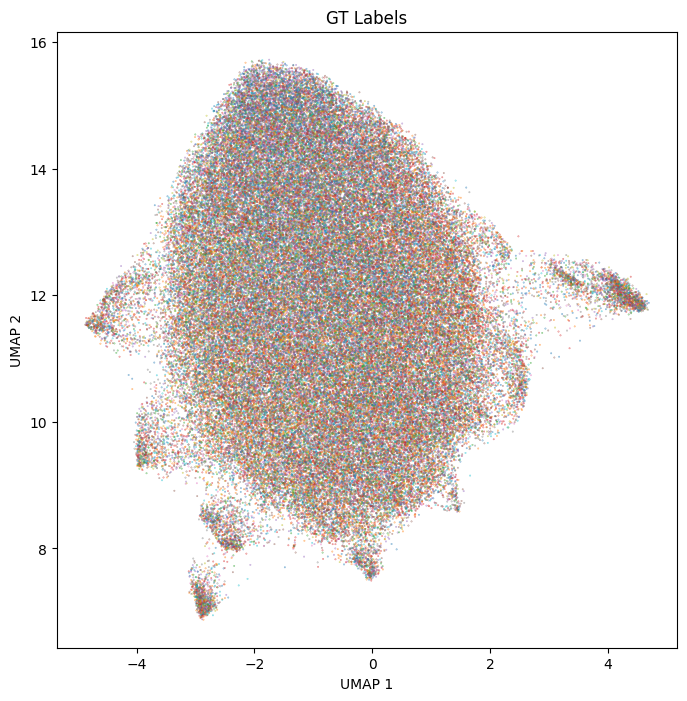

In [212]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(umap_data[:, 0], umap_data[:, 1], c=colors, s=0.1, alpha=0.7)
plt.title('GT Labels')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')